# Classification Model (AI Lab Run)
- B06: this time we want to check, whether for phoneme prediction training the model's cross attention will show any interesting tendency. 

## Preparing

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from model_model import CTCPredNetV1 as TheLearner
from model_dataset import DS_Tools
from model_dataset import WordDatasetPhoneseq as ThisDataset
from model_dataset import Normalizer, DeNormalizer, TokenMap
from model_dataset import MelSpecTransformDB as TheTransform
from paths import *
from misc_my_utils import *
from misc_recorder import *
from model_loss import *
from model_padding import generate_mask_from_lengths_mat

### Dirs

In [3]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

### Constants

In [4]:
BATCH_SIZE = 512

IN_DIM = 64
HID_DIM = 8

ENC_SIZE_LIST = {
    "in": 64, 
    "hid": 8
}
DEC_SIZE_LIST = {
    "hid": 8
}

DROPOUT = 0.5
NUM_LAYERS = 2
EMBEDDING_DIM = 128

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 32

## Prepare for this time of training

In [5]:
ts = str(get_timestamp())
ts = "0223155357"
stop_epoch = "29"
train_name = "B_06"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)
print(f"{train_name}-{ts}")

train_losses = ListRecorder(os.path.join(model_save_dir, "train.loss"))
train_recon_losses = ListRecorder(os.path.join(model_save_dir, "train.recon.loss"))
train_embedding_losses = ListRecorder(os.path.join(model_save_dir, "train.embedding.loss"))
train_commitment_losses = ListRecorder(os.path.join(model_save_dir, "train.commitment.loss"))

valid_losses = ListRecorder(os.path.join(model_save_dir, "valid.loss"))
valid_recon_losses = ListRecorder(os.path.join(model_save_dir, "valid.recon.loss"))
valid_embedding_losses = ListRecorder(os.path.join(model_save_dir, "valid.embedding.loss"))
valid_commitment_losses = ListRecorder(os.path.join(model_save_dir, "valid.commitment.loss"))

text_hist = HistRecorder(os.path.join(model_save_dir, "trainhist.txt"))

B_06-0223155357


- 0223155357: first trial of VQ-predictor. I am not sure whethe this will work. In case it doesn't, we will return to normal encoder, instead of VQ encoder. 

In [7]:
READ = False
DATAREAD = False

In [8]:
with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    # Load the object from the file
    mylist = pickle.load(file)
    mylist = ["BLANK"] + mylist

# Now you can use the loaded object
mymap = TokenMap(mylist)

mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

train_ds = ThisDataset(rec_dir, 
                       train_guide_path, 
                       mapper=mymap, 
                       transform=mytrans, 
                       ground_truth_path=os.path.join(src_, "train-phoneseq.gt"))
valid_ds = ThisDataset(rec_dir, 
                       valid_guide_path, 
                       mapper=mymap, 
                       transform=mytrans, 
                       ground_truth_path=os.path.join(src_, "valid-phoneseq.gt"))

use_proportion = 0.5

if READ or DATAREAD: 
    train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.use"))
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

    use_train_ds = torch.utils.data.Subset(train_ds, train_ds_indices)
    use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)
else: 
    # train data
    use_len = int(use_proportion * len(train_ds))
    remain_len = len(train_ds) - use_len
    use_train_ds, remain_ds = random_split(train_ds, [use_len, remain_len])

    # valid data
    use_len = int(use_proportion * len(valid_ds))
    remain_len = len(valid_ds) - use_len
    use_valid_ds, remain_ds = random_split(valid_ds, [use_len, remain_len])

    # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
    # the saved train and valid separations will reflect this
    DS_Tools.save_indices(os.path.join(model_save_dir, "train.use"), use_train_ds.indices)
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid.use"), use_valid_ds.indices)

train_loader = DataLoader(use_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)

In [9]:
train_num, valid_num, len(train_loader), len(valid_loader)

(386384, 51904, 755, 102)

torch.Size([512, 75, 64])


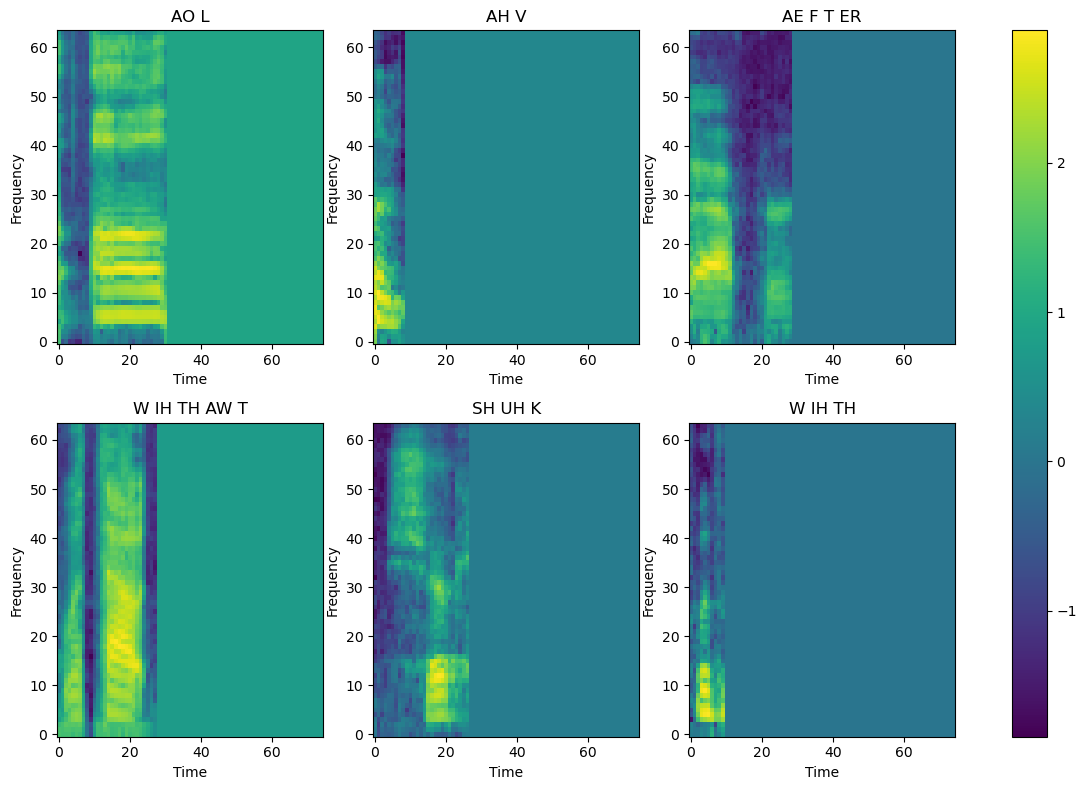

In [10]:
# Load sample data from train_loader
sample_data = next(iter(valid_loader))
xx_pad, x_lens, yy_pad, y_lens = sample_data
print(xx_pad.shape)

# Set the random seed for reproducibility
# random.seed(101)
# Generate six random indices
# random_indices = random.sample(range(len(xx_pad)), 6)
random_indices = list(range(6, 12))

# Plot the spectrograms and mark the corresponding seg
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    spectrogram = xx_pad[idx]
    title = " ".join([mymap.decode(yy_pad[idx][i].item()) for i in range(y_lens[idx])])
    
    ax = axes[i]
    img = ax.imshow(spectrogram.T, aspect='auto', origin="lower")
    # ax.axvline(x=segment, color='red', linestyle='--')
    # ax.axvline(x=segment[1], color='red', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.colorbar(img,ax=axes)
plt.show()

## Loss
VAE的损失由重构损失和KL损失组成.

KL散度就不再推导了, 直接放结果:
$$KL\Big(N(\mu,\sigma^2)\Big\Vert N(0,1)\Big)=\frac{1}{2}\Big(-\log \sigma^2+\mu^2+\sigma^2-1\Big)$$

VAE的目标是最小化$Z$和$\mathcal{N}(0, I)$之间的KL散度, 代码只需要照着写就行了:

In [11]:
masked_loss = MaskedLoss(loss_fn=nn.MSELoss(reduction="none"))
ctc_loss = nn.CTCLoss(blank=mymap.encode("BLANK"))

## Prepare Model
先定义好训练的epoch和batch_size, 优化器随便选一个世界上最好的优化器Adam(lr=1e-3):

In [12]:
DEC_SIZE_LIST["class"] = mymap.token_num()

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TheLearner(enc_size_list=ENC_SIZE_LIST, 
                   dec_size_list=DEC_SIZE_LIST, 
                   embedding_dim=EMBEDDING_DIM, 
                   num_layers=NUM_LAYERS, dropout=DROPOUT)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_str = str(model)
model_txt_path = os.path.join(model_save_dir, "model.txt")

with open(model_txt_path, "w") as f:
    f.write(model_str)

In [14]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

# initialize model weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.LSTM): 
        for name, p in m.named_parameters():
            if "weight" in name: 
                nn.init.orthogonal_(p)
            elif "bias" in name: 
                nn.init.constant_(p, 0)

model.apply(init_weights)

5072


CTCPredNetV1(
  (encoder): CTCEncoderV1(
    (lin_1): Linear(in_features=64, out_features=8, bias=True)
    (rnn): LSTM(8, 8, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (lin_2): Linear(in_features=16, out_features=8, bias=True)
    (act): ReLU()
  )
  (decoder): CTCDecoderV1(
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=8, out_features=8, bias=True)
      (w_k): Linear(in_features=8, out_features=8, bias=True)
      (w_v): Linear(in_features=8, out_features=8, bias=True)
    )
    (lin_2): Linear(in_features=8, out_features=40, bias=True)
    (softmax): LogSoftmax(dim=-1)
  )
  (vq_embedding): Embedding(128, 8)
)

### Load model if READ

In [15]:
if READ: 
    train_losses.read()
    train_recon_losses.read()
    train_embedding_losses.read()
    train_commitment_losses.read()

    valid_losses.read()
    valid_recon_losses.read()
    valid_embedding_losses.read()
    valid_commitment_losses.read()

    model_name = "{}.pt".format(stop_epoch)
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

## Training

In [16]:
l_w_embedding = 1
l_w_commitment = 0.25

In [17]:
EPOCHS = 100
BASE = 0

In [18]:
for epoch in range(BASE, BASE + EPOCHS):
    text_hist.print("Epoch {}".format(epoch))

    model.train()
    train_loss = 0.
    train_cumulative_l_reconstruct = 0.
    train_cumulative_l_embedding = 0.
    train_cumulative_l_commitment = 0.
    train_num = len(train_loader.dataset)    # train_loader
    for idx, (x, x_lens, y, y_lens) in enumerate(train_loader):
        current_batch_size = x.shape[0]
        # y_lens should be the same as x_lens
        optimizer.zero_grad()
        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        x = x.to(device)
        y = y.to(device)
        y = y.long()

        x_hat, attn_w, (ze, zq) = model(x, x_lens, x_mask)
        # Here x_hat: (B, L, C); we change to (L, B, C)
        x_hat = x_hat.permute(1, 0, 2)

        l_reconstruct = ctc_loss(x_hat, y, x_lens, y_lens)
        l_embedding = masked_loss.get_loss(ze.detach(), zq, x_mask)
        l_commitment = masked_loss.get_loss(ze, zq.detach(), x_mask)
        loss = l_reconstruct + \
            l_w_embedding * l_embedding + l_w_commitment * l_commitment

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
        optimizer.step()

        train_loss += loss.item() * current_batch_size
        train_cumulative_l_reconstruct += l_reconstruct.item() * current_batch_size
        train_cumulative_l_embedding += l_embedding.item() * current_batch_size
        train_cumulative_l_commitment += l_commitment.item() * current_batch_size

        if idx % 100 == 0:
            text_hist.print(f"""Training step {idx} loss {loss: .3f} \t recon {l_reconstruct: .3f} \t embed {l_embedding: .3f} \t commit {l_commitment: .3f}""")

    train_losses.append(train_loss / train_num)
    train_recon_losses.append(train_cumulative_l_reconstruct / train_num)
    train_embedding_losses.append(train_cumulative_l_embedding / train_num)
    train_commitment_losses.append(train_cumulative_l_commitment / train_num)

    text_hist.print(f"""※※※Training loss {train_loss / train_num: .3f} \t recon {train_cumulative_l_reconstruct / train_num: .3f} \t embed {train_cumulative_l_embedding / train_num: .3f} \t commit {train_cumulative_l_commitment / train_num: .3f}※※※""")

    last_model_name = "{}.pt".format(epoch)
    torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))


    model.eval()
    valid_loss = 0.
    valid_cumulative_l_reconstruct = 0.
    valid_cumulative_l_embedding = 0.
    valid_cumulative_l_commitment = 0.
    valid_num = len(valid_loader.dataset)
    for idx, (x, x_lens, y, y_lens) in enumerate(valid_loader):
        current_batch_size = x.shape[0]
        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)

        x = x.to(device)
        y = y.to(device)
        y = y.long()

        x_hat, attn_w, (ze, zq) = model(x, x_lens, x_mask)
        x_hat = x_hat.permute(1, 0, 2)

        l_reconstruct = ctc_loss(x_hat, y, x_lens, y_lens)
        l_embedding = masked_loss.get_loss(ze.detach(), zq, x_mask)
        l_commitment = masked_loss.get_loss(ze, zq.detach(), x_mask)
        loss = l_reconstruct + \
            l_w_embedding * l_embedding + l_w_commitment * l_commitment

        valid_loss += loss.item() * current_batch_size
        valid_cumulative_l_reconstruct += l_reconstruct.item() * current_batch_size
        valid_cumulative_l_embedding += l_embedding.item() * current_batch_size
        valid_cumulative_l_commitment += l_commitment.item() * current_batch_size

    text_hist.print(f"""※※※Valid loss {valid_loss / valid_num: .3f} \t recon {valid_cumulative_l_reconstruct / valid_num: .3f} \t embed {valid_cumulative_l_embedding / valid_num: .3f} \t commit {valid_cumulative_l_commitment / valid_num: .3f}※※※""")
    valid_losses.append(valid_loss / valid_num)
    valid_recon_losses.append(valid_cumulative_l_reconstruct / valid_num)
    valid_embedding_losses.append(valid_cumulative_l_embedding / valid_num)
    valid_commitment_losses.append(valid_cumulative_l_commitment / valid_num)

Epoch 0
Training step 0 loss  22.530 	 recon  22.525 	 embed  0.004 	 commit  0.004
Training step 100 loss  25.832 	 recon  14.957 	 embed  8.700 	 commit  8.700
Training step 200 loss  32.337 	 recon  4.047 	 embed  22.633 	 commit  22.633
Training step 300 loss  24.007 	 recon  3.975 	 embed  16.026 	 commit  16.026
Training step 400 loss  18.596 	 recon  3.915 	 embed  11.745 	 commit  11.745
Training step 500 loss  15.151 	 recon  3.914 	 embed  8.990 	 commit  8.990
Training step 600 loss  11.544 	 recon  3.904 	 embed  6.112 	 commit  6.112
Training step 700 loss  4.151 	 recon  3.920 	 embed  0.185 	 commit  0.185
※※※Training loss  18.680 	 recon  6.502 	 embed  9.742 	 commit  9.742※※※
※※※Valid loss  4.281 	 recon  4.101 	 embed  0.144 	 commit  0.144※※※
Epoch 1
Training step 0 loss  4.095 	 recon  3.887 	 embed  0.167 	 commit  0.167
Training step 100 loss  4.067 	 recon  3.870 	 embed  0.158 	 commit  0.158
Training step 200 loss  3.950 	 recon  3.930 	 embed  0.016 	 commit 

觉得Loss位数保留太多的可以自己设置.

下面画出训练过程中训练集和验证集上的损失曲线:

In [19]:
train_losses.save()
train_recon_losses.save()
train_embedding_losses.save()
train_commitment_losses.save()
valid_losses.save()
valid_recon_losses.save()
valid_embedding_losses.save()
valid_commitment_losses.save()

Text(0.5, 1.0, 'Learning Curve Commitment Loss')

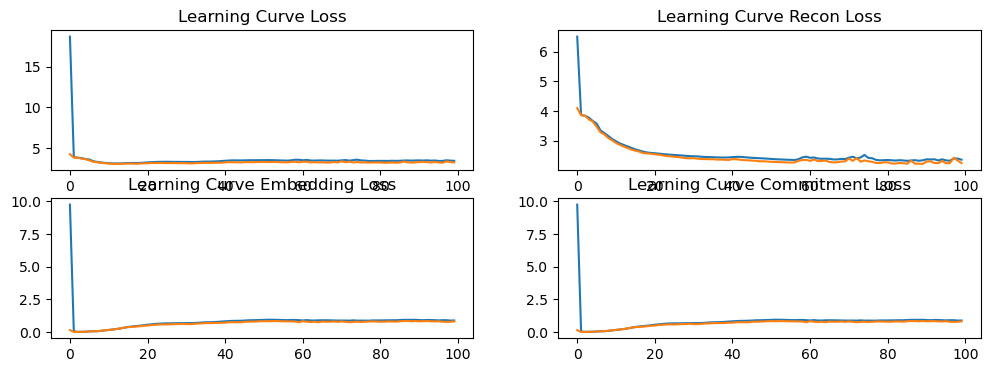

In [22]:
start, end = 0, 100

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 4))
# Plot Loss on the left subplot
ax1.plot(train_losses.get()[start:end], label='Train')
ax1.plot(valid_losses.get()[start:end], label='Valid')
ax1.set_title("Learning Curve Loss")

# Plot Recon Loss on the right subplot
ax2.plot(train_recon_losses.get()[start:end], label='Train')
ax2.plot(valid_recon_losses.get()[start:end], label='Valid')
ax2.set_title("Learning Curve Recon Loss")

# Plot Embedding Loss on the left subplot
ax3.plot(train_embedding_losses.get()[start:end], label='Train')
ax3.plot(valid_embedding_losses.get()[start:end], label='Valid')
ax3.set_title("Learning Curve Embedding Loss")

# Plot Commitment Loss on the right subplot
ax4.plot(train_commitment_losses.get()[start:end], label='Train')
ax4.plot(valid_commitment_losses.get()[start:end], label='Valid')
ax4.set_title("Learning Curve Commitment Loss")

In [23]:
l_reconstruct, l_embedding, l_commitment

(tensor(2.2152, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.8035, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.8035, device='cuda:0', grad_fn=<DivBackward0>))

基本上Valid Loss稳定了(其实还有下降空间). 同时要保存在验证集上结果最好的模型, 因为等会还要用最好的模型做生成.

In [24]:
ts

'0223155357'

## Testing

In [27]:
import torchaudio
from tqdm import tqdm
from torchaudio.models.decoder import ctc_decoder

In [28]:
CTCDecoder = ctc_decoder(
    lexicon=None, 
    tokens=mylist + ["|"], 
    blank_token="BLANK"
)

In [29]:
test_ds = ThisDataset(rec_dir, 
                       test_guide_path, 
                       mapper=mymap, 
                       transform=mytrans, 
                       ground_truth_path=os.path.join(src_, "test-phoneseq.gt"))

use_proportion = 0.1

if READ or DATAREAD: 
    test_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "test.use"))
    use_test_ds = torch.utils.data.Subset(test_ds,test_ds_indices)
else: 
    # train data
    use_len = int(use_proportion * len(test_ds))
    remain_len = len(test_ds) - use_len
    use_test_ds, remain_ds = random_split(test_ds, [use_len, remain_len])
    DS_Tools.save_indices(os.path.join(model_save_dir, "test.use"), use_train_ds.indices)

test_loader = DataLoader(use_test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn_yNoPad)
test_num = len(test_loader.dataset)

In [32]:
model.eval()
test_loss = 0.
test_num = len(test_loader)
preds = []
reals = []
attns = []
for (x, x_lens, y, y_lens) in tqdm(test_loader):
    x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
    
    x = x.to(device)
    # y = y.to(device)
    # y = y.long()

    x_hat, attn_w, (ze, zq) = model(x, x_lens, x_mask)

    preds += CTCDecoder(x_hat.cpu())
    reals += y
    attns += [attn_w]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [02:25<00:00,  7.29s/it]


In [33]:
total_per = 0
total = 0
for real, pred in zip(reals, preds): 
    total_per += torchaudio.functional.edit_distance(real, pred[0].tokens[1:-1]) / len(real)
    total += 1

In [39]:
i = torch.randint(0, total, size=(1, )).item()
print([mymap.decode(x.item()) for x in reals[i]])
print([mymap.decode(x.item()) for x in preds[i][0].tokens[1:-1]])

['L', 'EH', 'V', 'IH', 'S', 'AH', 'N']
['AH', 'AH', 'S', 'AH', 'N']


In [35]:
total_per / total

0.686890856220109

In [44]:
import matplotlib.pyplot as plt
import numpy as np

['D', 'EY', 'N', 'JH', 'ER', 'AH', 'S']
['EY', 'T', 'AH', 'Z']


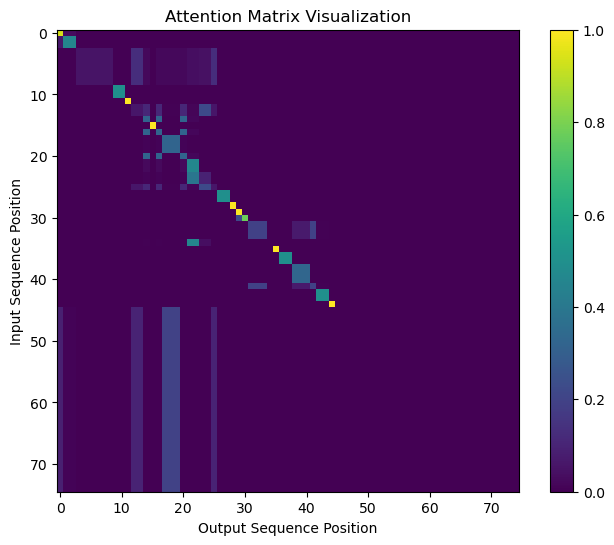

In [63]:
# Assuming 'attention_matrix' is a numpy array of shape (len, len)
# For demonstration, let's create a sample attention matrix
i = torch.randint(0, total, size=(1, )).item()
attention_matrix = attns[i//512][i%512]
print([mymap.decode(x.item()) for x in reals[i]])
print([mymap.decode(x.item()) for x in preds[i][0].tokens[1:-1]])

# Plotting the attention matrix
plt.figure(figsize=(8, 6))
plt.imshow(attention_matrix.detach().cpu().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Attention Matrix Visualization')
plt.xlabel('Output Sequence Position')
plt.ylabel('Input Sequence Position')
plt.show()
